# Evaluators

At a high-level, an evaluator judges an invocation of your LLM application against a reference example, and returns an evaluation score.

In LangSmith evaluators, we represent this process as a function that takes in a Run (representing the LLM app invocation) and an Example (representing the data point to evaluate), and returns Feedback (representing the evaluator's score of the LLM app invocation).

![Evaluator](../../images/evaluator.png)

Here is an example of a very simple custom evaluator that compares the output of a model to the expected output in the dataset:

In [1]:
from langsmith.schemas import Example, Run

def correct_label(inputs: dict, reference_outputs: dict, outputs: dict) -> dict:
  score = outputs.get("output") == reference_outputs.get("label")
  return {"score": int(score), "key": "correct_label"}

### LLM-as-Judge Evaluation

LLM-as-judge evaluators use LLMs to score system output. To use them, you typically encode the grading rules / criteria in the LLM prompt. They can be reference-free (e.g., check if system output contains offensive content or adheres to specific criteria). Or, they can compare task output to a reference (e.g., check if the output is factually accurate relative to the reference).

Here is an example of how you might define an LLM-as-judge evaluator with structured output

In [1]:
# Or you can use a .env file
from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

In [2]:
from openai import OpenAI
from pydantic import BaseModel, Field

client = OpenAI()

class Similarity_Score(BaseModel):
    similarity_score: int = Field(description="Semantic similarity score between 1 and 10, where 1 means unrelated and 10 means identical.")

# NOTE: This is our evaluator
def compare_semantic_similarity(inputs: dict, reference_outputs: dict, outputs: dict):
    input_question = inputs["question"]
    reference_response = reference_outputs["output"]
    run_response = outputs["output"]
    
    completion = client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=[
            {   
                "role": "system",
                "content": (
                    "You are a semantic similarity evaluator. Compare the meanings of two responses to a question, "
                    "Reference Response and New Response, where the reference is the correct answer, and we are trying to judge if the new response is similar. "
                    "Provide a score between 1 and 10, where 1 means completely unrelated, and 10 means identical in meaning."
                ),
            },
            {"role": "user", "content": f"Question: {input_question}\n Reference Response: {reference_response}\n Run Response: {run_response}"}
        ],
        response_format=Similarity_Score,
    )

    similarity_score = completion.choices[0].message.parsed
    return {"score": similarity_score.similarity_score, "key": "similarity"}


Let's try this out!

NOTE: We purposely made this answer wrong, so we expect to see a low score.

In [4]:
# From Dataset Example
inputs = {
  "question": "Is LangSmith natively integrated with LangChain?"
}
reference_outputs = {
  "output": "Yes, LangSmith is natively integrated with LangChain, as well as LangGraph."
}


# From Run
outputs = {
  "output": "No, LangSmith is NOT integrated with LangChain."
}

similarity_score = compare_semantic_similarity(inputs, reference_outputs, outputs)
print(f"Semantic similarity score: {similarity_score}")

Semantic similarity score: {'score': 1, 'key': 'similarity'}


You can also define evaluators using Run and Example directly!

In [5]:
from langsmith.schemas import Run, Example

def compare_semantic_similarity_v2(root_run: Run, example: Example):
    input_question = example["inputs"]["question"]
    reference_response = example["outputs"]["output"]
    run_response = root_run["outputs"]["output"]
    
    completion = client.beta.chat.completions.parse(
        model="gpt-4o",
        messages=[
            {   
                "role": "system",
                "content": (
                    "You are a semantic similarity evaluator. Compare the meanings of two responses to a question, "
                    "Reference Response and New Response, where the reference is the correct answer, and we are trying to judge if the new response is similar. "
                    "Provide a score between 1 and 10, where 1 means completely unrelated, and 10 means identical in meaning."
                ),
            },
            {"role": "user", "content": f"Question: {input_question}\n Reference Response: {reference_response}\n Run Response: {run_response}"}
        ],
        response_format=Similarity_Score,
    )

    similarity_score = completion.choices[0].message.parsed
    return {"score": similarity_score.similarity_score, "key": "similarity"}

In [6]:
sample_run = {
  "name": "Sample Run",
  "inputs": {
    "question": "Is LangSmith natively integrated with LangChain?"
  },
  "outputs": {
    "output": "No, LangSmith is NOT integrated with LangChain."
  },
  "is_root": True,
  "status": "success",
  "extra": {
    "metadata": {
      "key": "value"
    }
  }
}

sample_example = {
  "inputs": {
    "question": "Is LangSmith natively integrated with LangChain?"
  },
  "outputs": {
    "output": "Yes, LangSmith is natively integrated with LangChain, as well as LangGraph."
  },
  "metadata": {
    "dataset_split": [
      "AI generated",
      "base"
    ]
  }
}

similarity_score = compare_semantic_similarity_v2(sample_run, sample_example)
print(f"Semantic similarity score: {similarity_score}")

Semantic similarity score: {'score': 1, 'key': 'similarity'}


Creating my own evaulator using llm in langsmith:

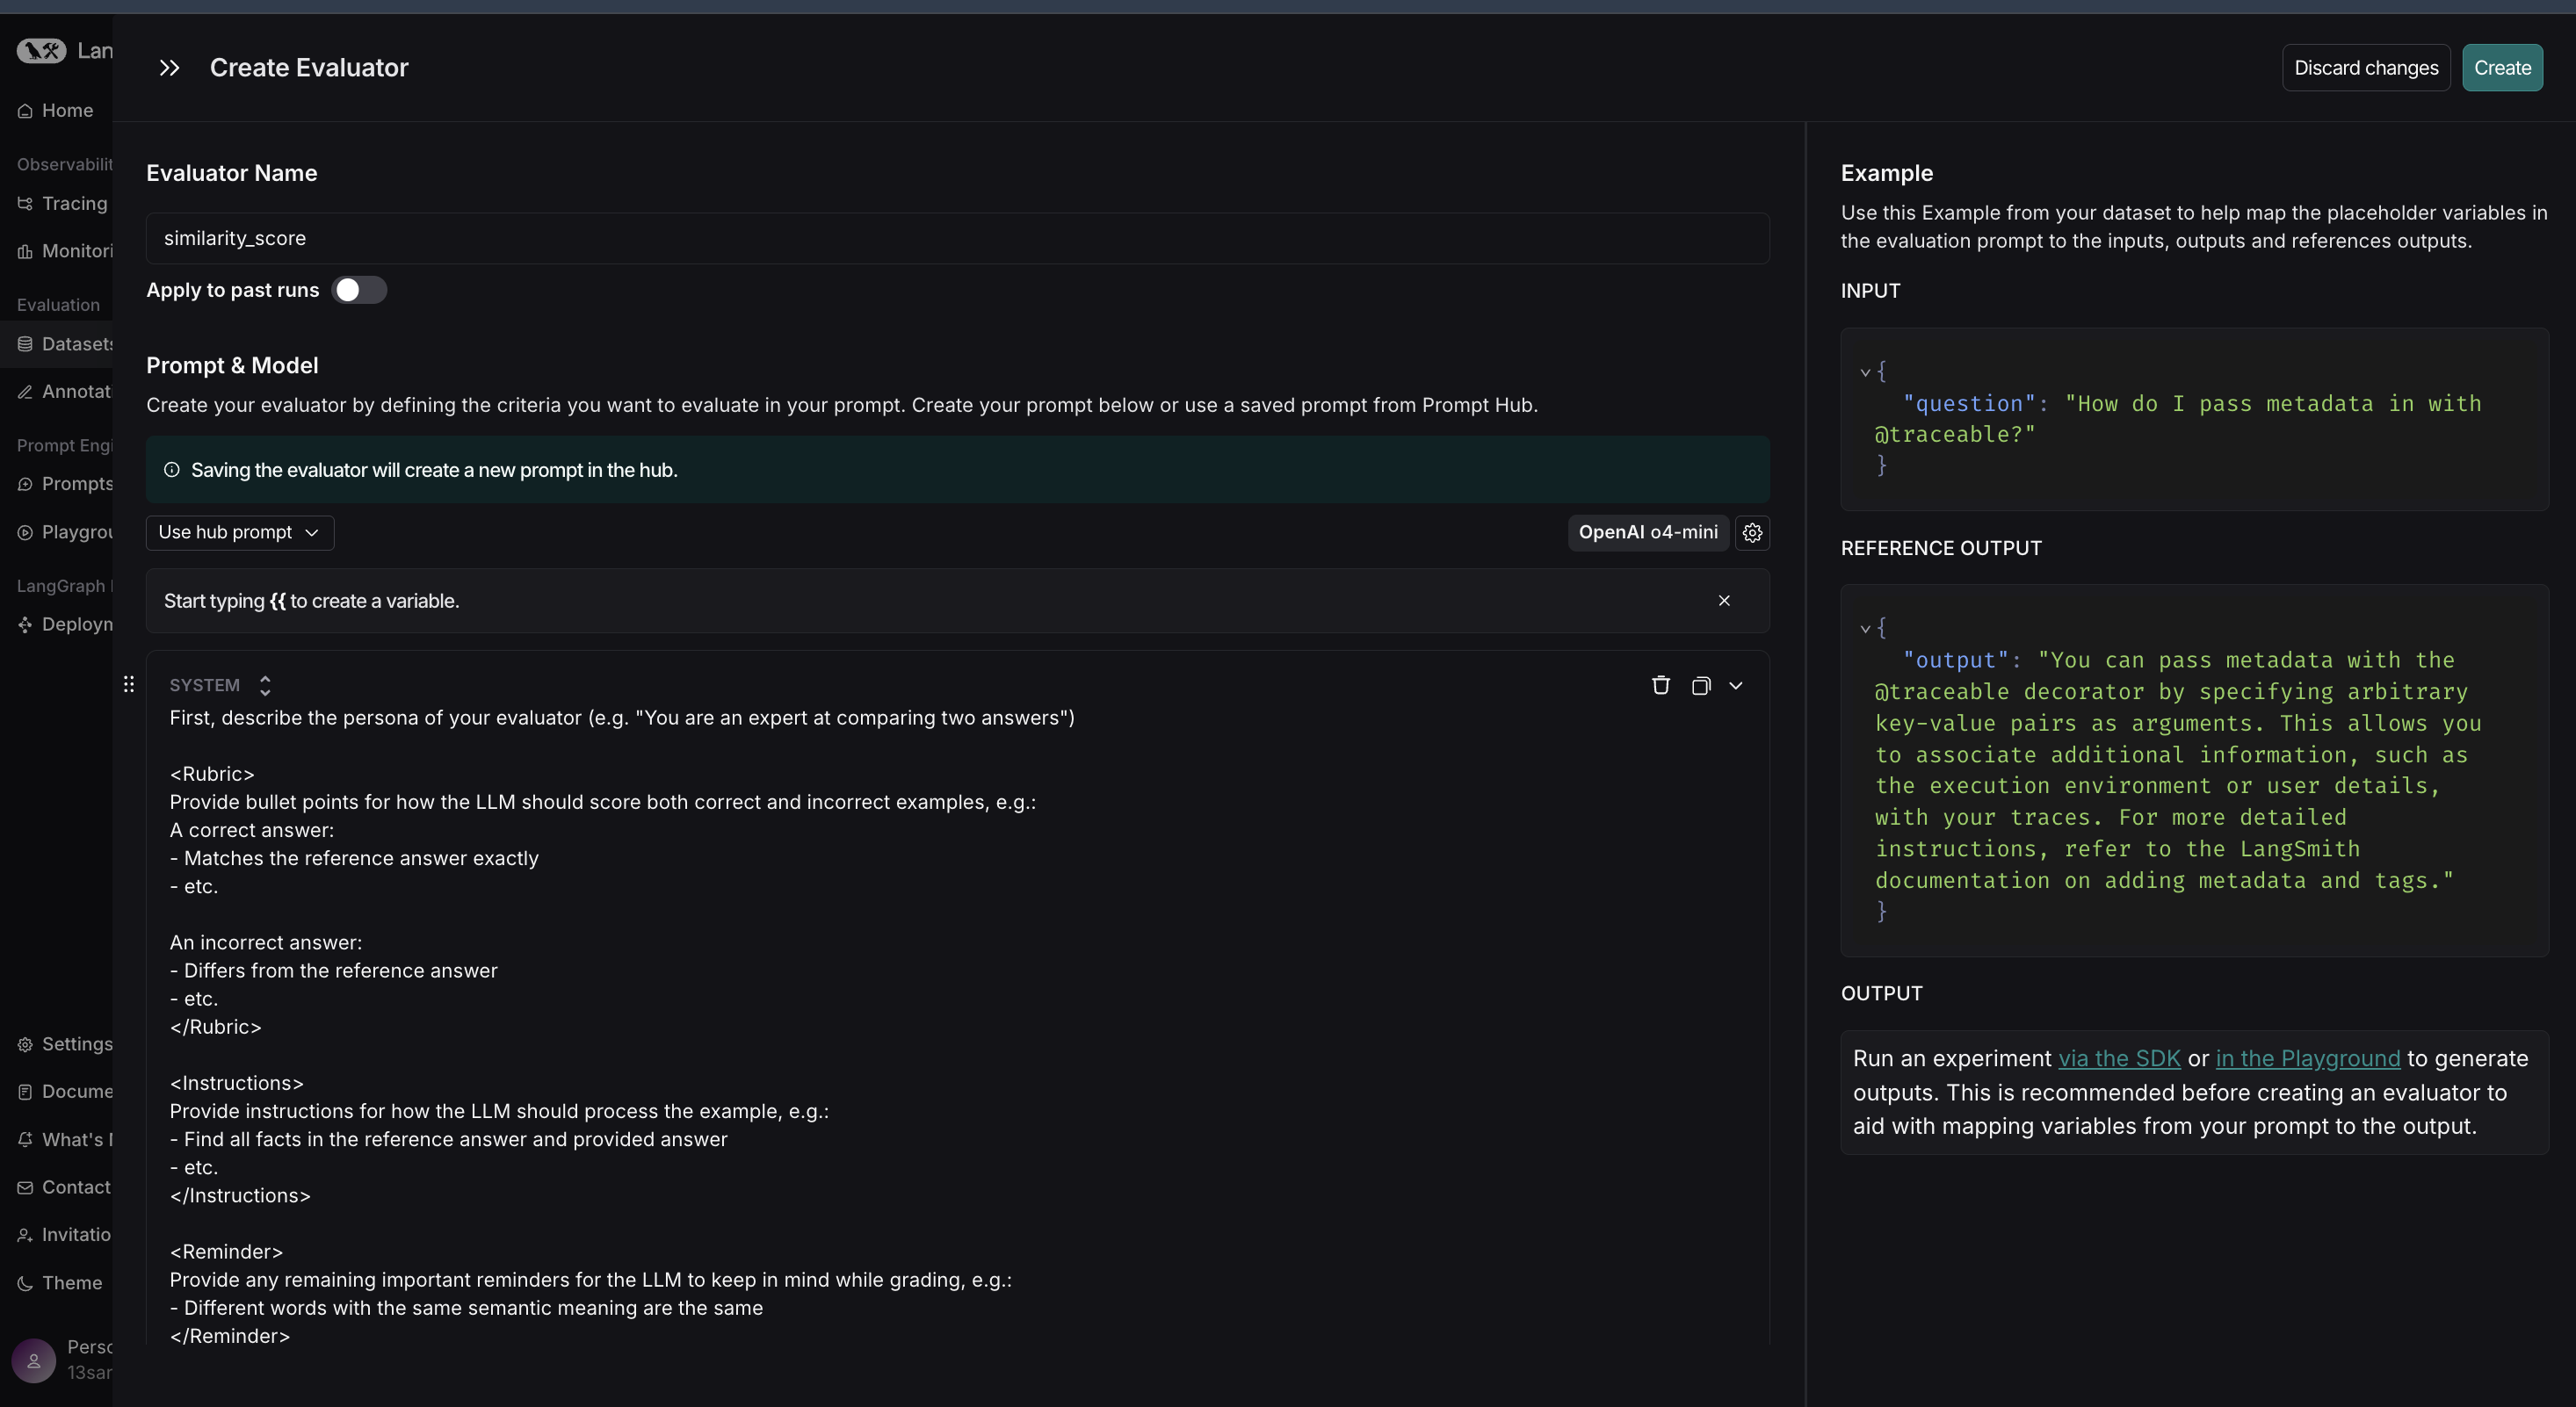

W e can also create our own custom evaluator in langsmith and test it directly there:

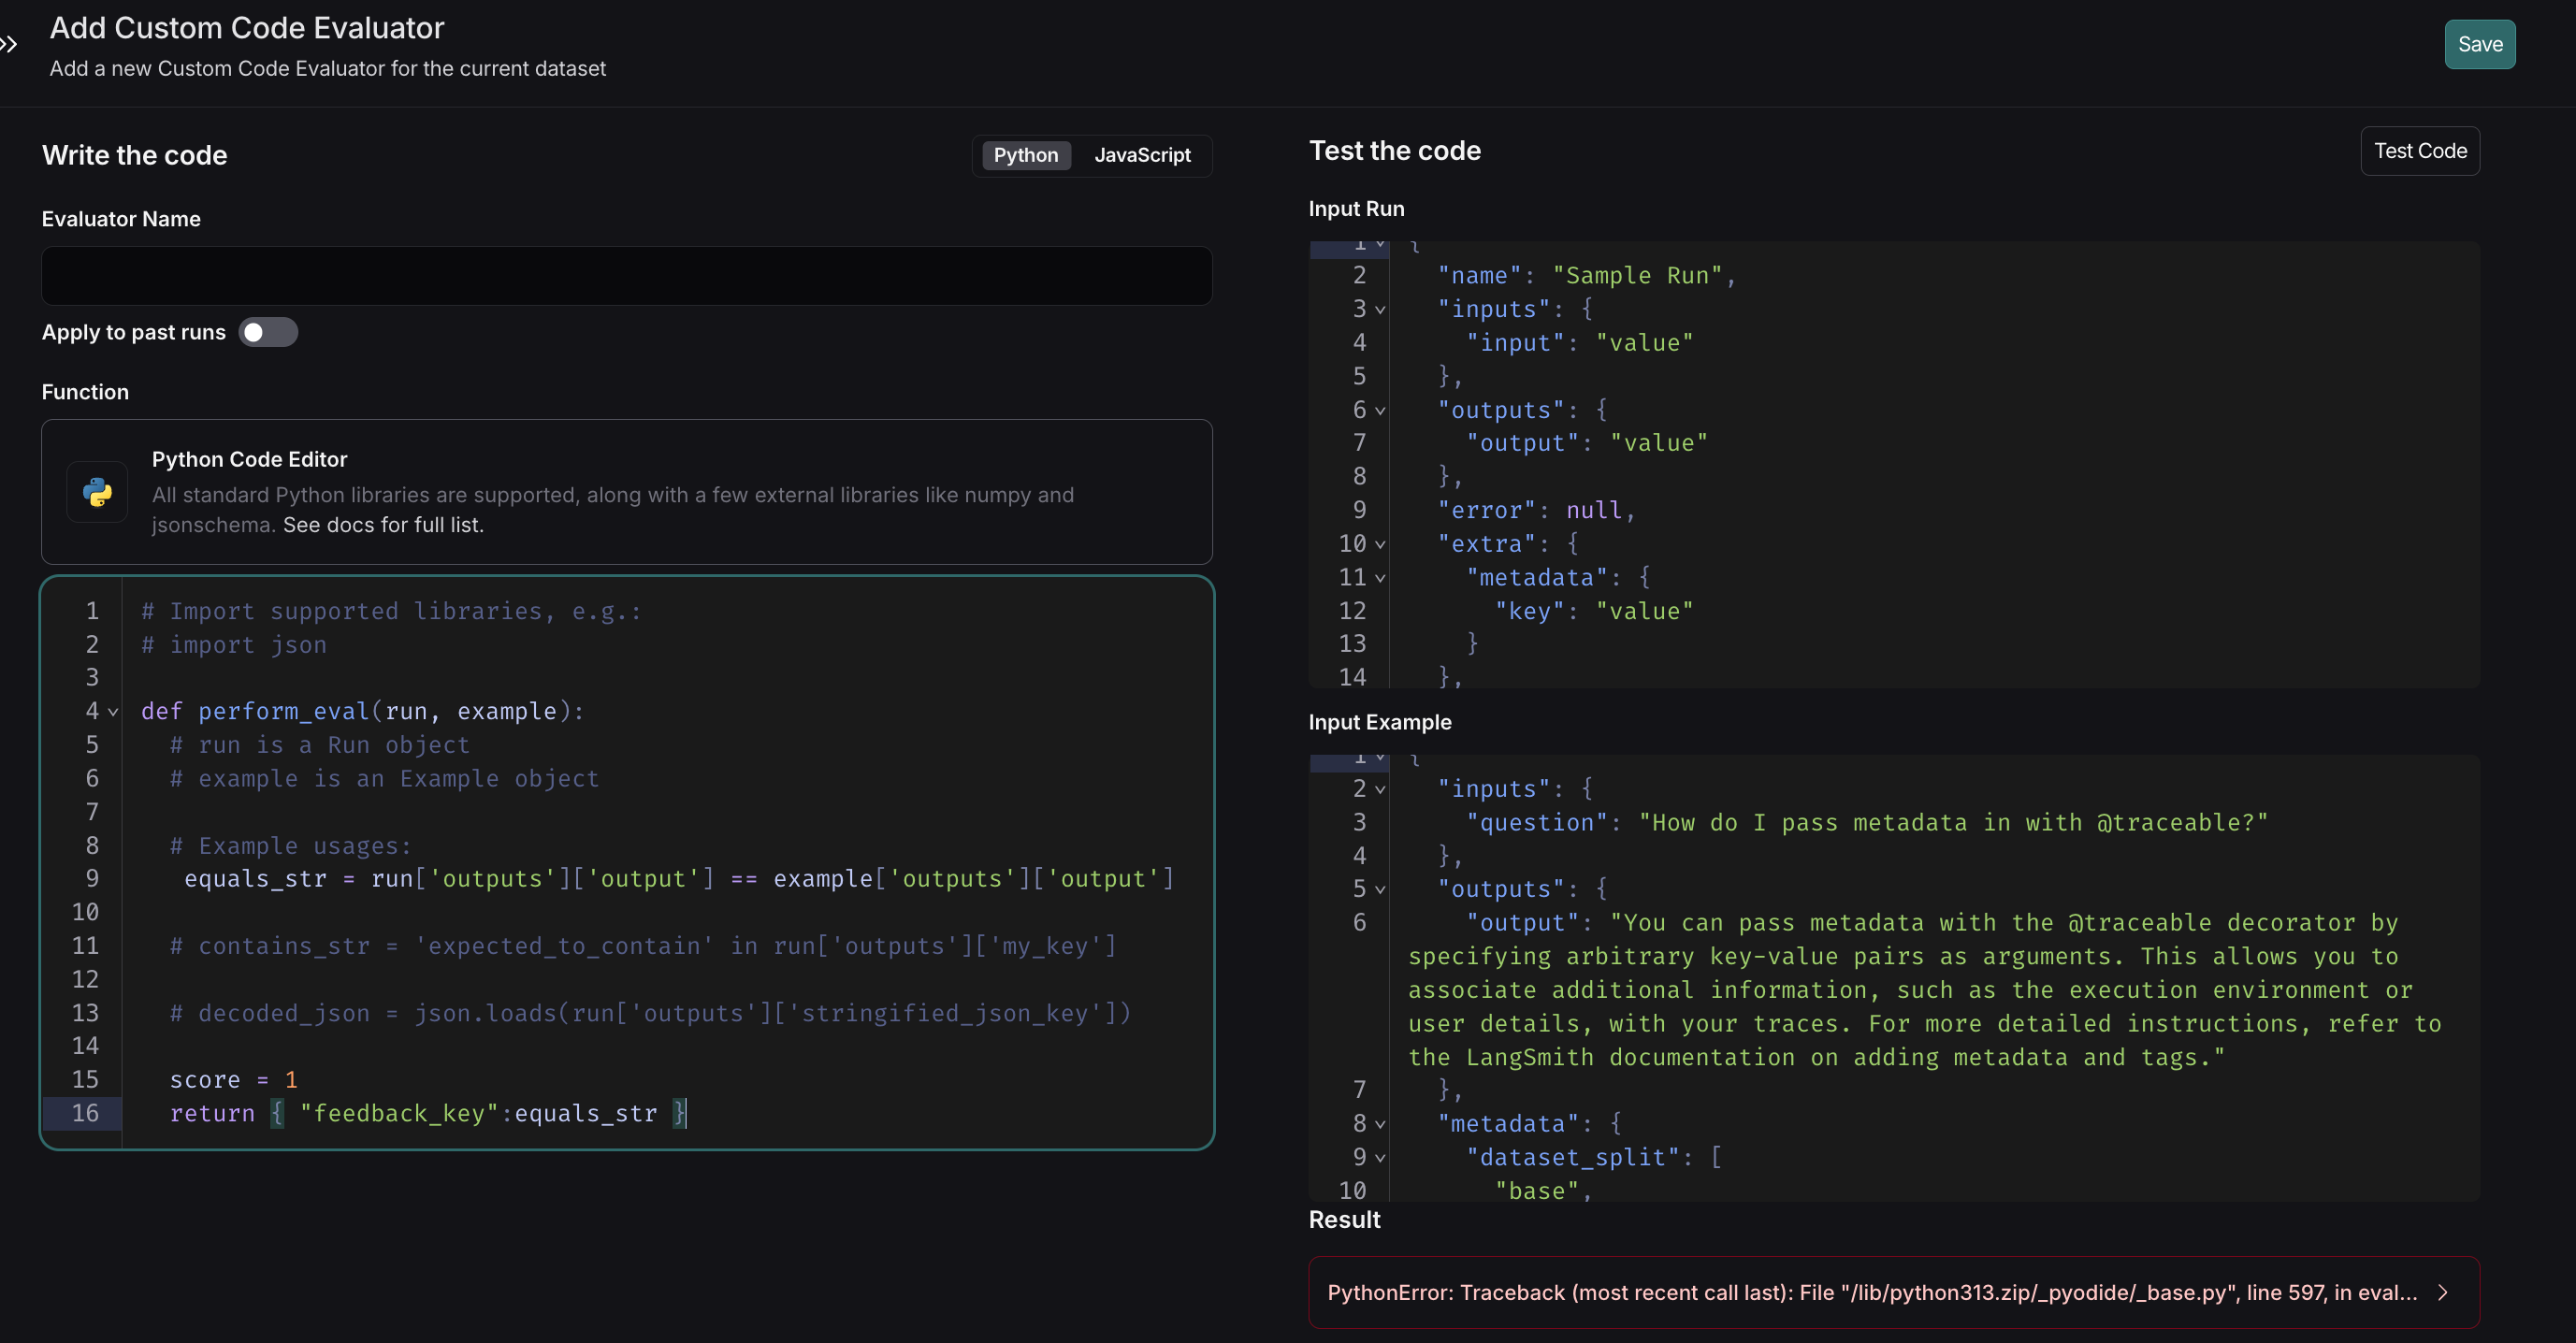